# Comparison of all the obtained models

This notebook containes evaluation of all models that were built in the project.

|Model|Class|Recall|F1|Macro average|Features used|
|--|--|--|--|--|--|
|[baseline](models/baseline.py)||||
|[logreg_full](models/logred_full.pkl)|Logistic regression||||Full set (but `client_id`and `creation_date`|
|[random_forest](models/random_forest.pkl)|Random forest||||Full set (but `client_id` and `creation_date`|
|[tree_gini](models/decision_tree_gini.pkl)|Decision tree|||| ....|
|[knn](models/knn.pkl)|KNN||||`client_catg`,`region`, `total_consum_lvl<1-4>_mean`|
|[xgb]()|XGBoost||||Full set without `client_id`and `creation_date` and consumption by month|

## Imports

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pickle import load, dump

from eval_metrics_katja import *

Data

In [36]:
df = pd.read_csv('data/merged_df_full.csv')
df.head()

,district,client_id,client_catg,region,creation_date,target,acc_creation_year,acc_creation_month,acc_creation_weekday,total_consum_lvl1_mean,...,gaz_1_mon_3,gaz_1_mon_4,gaz_1_mon_5,gaz_1_mon_6,gaz_1_mon_7,gaz_1_mon_8,gaz_1_mon_9,gaz_1_mon_10,gaz_1_mon_11,gaz_1_mon_12
0,60,0,11,101,1994-12-31,0.0,1994,12,5,352.400000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,69,1,11,107,2002-05-29,0.0,2002,5,2,557.540541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,62,10,11,301,1986-03-13,0.0,1986,3,3,798.611111,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,69,100,11,105,1996-07-11,0.0,1996,7,3,1.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,62,1000,11,303,2014-10-14,0.0,2014,10,1,663.714286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
gas_cols = ['gaz_1_mon_'+str(mon) for mon in range(1,13)] 
#+ ['gaz_2_mon_'+str(mon) for mon in range(1,13)]
df[gas_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gaz_1_mon_1   32571 non-null  float64
 1   gaz_1_mon_2   33628 non-null  float64
 2   gaz_1_mon_3   34069 non-null  float64
 3   gaz_1_mon_4   34410 non-null  float64
 4   gaz_1_mon_5   37469 non-null  float64
 5   gaz_1_mon_6   34682 non-null  float64
 6   gaz_1_mon_7   35564 non-null  float64
 7   gaz_1_mon_8   32683 non-null  float64
 8   gaz_1_mon_9   32606 non-null  float64
 9   gaz_1_mon_10  32476 non-null  float64
 10  gaz_1_mon_11  34171 non-null  float64
 11  gaz_1_mon_12  29705 non-null  float64
dtypes: float64(12)
memory usage: 12.4 MB


Baseline model

In [15]:
df_invoice = pd.read_csv('data/invoice_train.csv')
df_client = pd.read_csv('data/client_train.csv')

/var/folders/4d/1242dr3d1kq37hdws_z3wlr00000gn/T/ipykernel_27859/1644681065.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_invoice = pd.read_csv('data/invoice_train.csv')


In [2]:
from sklearn.model_selection import train_test_split 

def preprocess(df):
    df['client_id'] = df.client_id.str.removeprefix('train_Client_').astype(int)
    # This renames the columns from consommation to consumption 
    # for the client_train.csv will do nothing
    df.columns = [col.replace('consommation', 'consumption') for col in df.columns]
    return df

def aggregate_by_client_id(invoice_data, agg_mode='mean'):
    aggs = {}
    aggs['consumption_level_1'] = [agg_mode]
    aggs['consumption_level_2'] = [agg_mode]
    aggs['consumption_level_3'] = [agg_mode]
    aggs['consumption_level_4'] = [agg_mode]

    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)

    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

def aggregate_and_split(df_invoice, df_client, agg_mode='mean', **kwargs):
    df_client = preprocess(df_client)
    df_invoice = preprocess(df_invoice)
    df_inv_agg = aggregate_by_client_id(df_invoice, agg_mode)
    df_full = pd.merge(df_client, df_inv_agg, 
                       on='client_id', how='left')
    target = df_full.pop('target')
    X_train, X_test, y_train, y_test = train_test_split(df_full, target, 
                                                        stratify=target,
                                                        random_state=42)

    return X_train, X_test, y_train, y_test

# Based on the region
## There is always fraud in "bad" regions
def bl_regions(df, out_format='np'):
    """The model that assumes Everyone in regions == bad_regions
    commits fraud

    Args:
        df: df_client or any other DataFrame that contains the `region`column
            and the client_id (for correspondence)
        out_format (str, optional): Defaults to 'np' which returns np.array.
                                    If anything else, returns a pandas.Series

    Returns:
        numpy.ndarray or pandas.Series: predictions
    """    
    bad_regions = [103, 106, 311, 372, 313, 371, 379, 304, 107, 104]
    X_train, X_test, y_train, y_test = train_test_split(df_client['region'], df_client['target'], 
                                                        stratify=df_client['target'],
                                                        random_state=42)
    prediction = X_test.isin(bad_regions).astype(int)
    if out_format == 'np':
        return prediction.values
    else:
        return prediction

# Based on consumption level

## Accounts with higher mean consumption are more likely to commit fraud

def bl_consump_std(df_invoice, df_client):

    # aggregate and split into train, test features and target
    # only the train features important here!
    df_full_train, df_full_test, _, _ = aggregate_and_split(
        df_invoice, df_client, agg_mode='std') # change the aggregation mode!
    
    df_full_test['consumption_total_std'] = df_full_test[
    ['consumption_level_1_std', 'consumption_level_2_std', 
     'consumption_level_3_std', 'consumption_level_4_std']].sum(axis=1)
    median = df_full_test['consumption_total_std'].median()
    prediction = (df_full_test['consumption_total_std'] > median).astype(int)#
    #prediction.rename('pred_by_mean_cons', inplace=True)
    return prediction.values


In [19]:
pred_cons = bl_consump_std(df_invoice, df_client)

In [22]:
pred_reg = bl_regions(df_client)

In [26]:
pred_bl = pred_reg & pred_cons

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_client['region'], df_client['target'], 
                                                        stratify=df_client['target'],
                                                        random_state=42)

In [30]:
from sklearn.metrics import f1_score, confusion_matrix

In [32]:
print("f1_score: {:.2f}".format(f1_score(y_test, pred_bl, average='weighted')))

f1_score: 0.16


In [33]:
from example_files.eval_metrics_katja import *

In [34]:
display_classification_report(y_test, pred_bl)

                Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87     31982
         1.0       0.10      0.38      0.16      1892

    accuracy                           0.77     33874
   macro avg       0.53      0.59      0.51     33874
weighted avg       0.91      0.77      0.83     33874



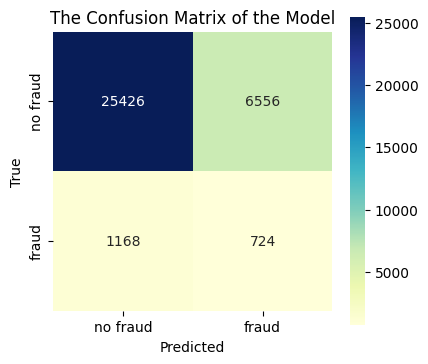

In [35]:
conf_matrix_display(y_test, pred_bl)

Trained models

-----

# Plots for the slides

In [36]:
model_types = ['Baseline', 'KNN', 'Decision Tree',  'XGBoost', 'Random Forest']
bm = 0.83
rf = 0.92
knn = 0.91
dt = 0.90
xgb = 0.93
f1_weighted = [bm, knn, dt, xgb, rf]
bm_normal = 0.16
rf_normal = 0.06
knn_normal = 0.09
dt_normal = 0.12
xgb_normal = 0.18
f1_normal = [bm_normal, knn_normal, dt_normal, xgb_normal, rf_normal]

In [53]:
msumm = pd.DataFrame(index=model_types, 
                     data={'f1_weighted': f1_weighted, 'f1': f1_normal})

In [54]:
msumm

,f1_weighted,f1
Baseline,0.83,0.16
KNN,0.91,0.09
Decision Tree,0.90,0.12
XGBoost,0.93,0.18
Random Forest,0.92,0.06


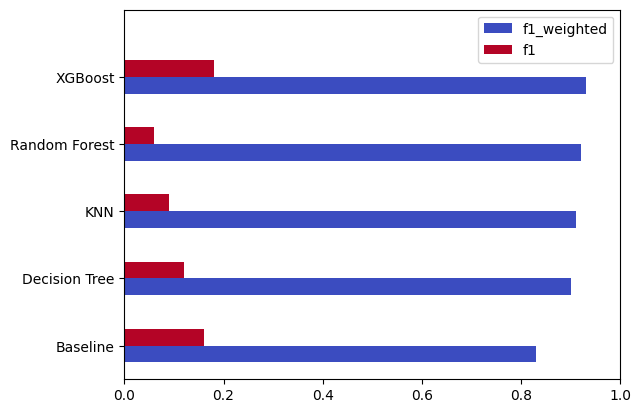

In [55]:
msumm.sort_values('f1_weighted').plot(kind='barh', colormap='coolwarm')
plt.xlim(0,1);
plt.ylim(-0.5,5);

##